In [ ]:
import gym
from gym import spaces
import numpy as np
import networkx as nx

class MISGraphEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, graph):
        super(MISGraphEnv, self).__init__()
        self.graph = graph
        self.n_nodes = len(graph.nodes)
        # Define action space (node index to act upon)
        self.action_space = spaces.Discrete(self.n_nodes)
        # Define observation space as binary for each node: 0 (excluded), 1 (included), 2 (undecided)
        self.observation_space = spaces.Box(low=0, high=2, shape=(self.n_nodes,), dtype=np.int8)
        # Initial state: all nodes are undecided (2)
        self.state = 2 * np.ones(self.n_nodes, dtype=np.int8)
        
    def step(self, action):
        if self.state[action] == 2:  # If undecided, decide to include the node
            self.state[action] = 1
            for neighbor in self.graph.neighbors(action):
                if self.state[neighbor] == 1:  # Conflict if neighbor also included
                    self.state[action] = 0  # Revert to excluded if conflict occurs
                    return self.state, -10, True, {}  # Penalize and end episode
                self.state[neighbor] = 0  # Exclude neighbors
            reward = np.sum(self.state == 1)  # Reward based on number of included nodes
        else:
            reward = -1  # Penalize redundant actions slightly
        
        done = np.all(self.state != 2)  # Check if all decisions are made
        return self.state, reward, done, {}
    
    def reset(self):
        self.state = 2 * np.ones(self.n_nodes, dtype=np.int8)  # Reset state to all undecided
        return self.state
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        pass


In [ ]:
from stable_baselines3 import PPO

# Create a simple cycle graph for demonstration
graph = nx.cycle_graph(5)
env = MISGraphEnv(graph)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)



In [ ]:
# Test the environment
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    print(f"Action: {action}, Reward: {rewards}")

In [ ]:
# Test the environment
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    # Ensure the action is an integer if necessary
    action = action.item() if isinstance(action, np.ndarray) else action
    obs, rewards, done, info = env.step(action)
    print(f"Action: {action}, Reward: {rewards}")



In [ ]:
def step(self, action):
    # Assume 'action' is an integer index for the node
    if self.state[action] == 2:  # If undecided
        self.state[action] = 1  # Decide to include the node
        # Process neighbors
        for neighbor in self.graph.neighbors(action):
            if self.state[neighbor] == 1:
                self.state[action] = 0  # Conflict: revert decision
                reward = -10
                return self.state, reward, True, {}
            self.state[neighbor] = 0  # Exclude neighbors
        reward = np.sum(self.state == 1)  # Reward is size of independent set
    else:
        reward = -1  # Penalize if action is redundant

    done = np.all(self.state != 2)  # Check if all nodes are decided
    return self.state, reward, done, {}


New something

In [ ]:
import gym
from gym import spaces
import numpy as np
import networkx as nx

class GraphMISEnv(gym.Env):
    def __init__(self, graph):
        super(GraphMISEnv, self).__init__()
        self.graph = nx.Graph(graph)
        self.num_nodes = len(self.graph.nodes())
        self.action_space = spaces.Discrete(self.num_nodes * 3)  # 3 actions per node
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.num_nodes,), dtype=np.int32)
        self.state = np.zeros(self.num_nodes, dtype=np.int32)  # Initial state: all nodes deferred

    def step(self, action):
        node = action // 3
        action_type = action % 3 - 1  # Maps to -1, 0, 1
        
        # Handle the action on the node
        prev_state = self.state[node]
        self.state[node] = action_type
        
        # Implement the effects of including or excluding a node
        reward = 0
        if action_type == 1:  # Included
            for neighbor in self.graph.neighbors(node):
                if self.state[neighbor] == 1:
                    reward -= 10  # Penalize if neighbor also included
                self.state[neighbor] = -1  # Automatically exclude neighbors
            reward += 1  # Reward for including a node
        
        done = np.all(self.state != 0)  # All nodes decided
        return self.state.copy(), reward, done, {}

    def reset(self):
        self.state = np.zeros(self.num_nodes, dtype=np.int32)  # Reset to all deferred
        return self.state.copy()

    def render(self, mode='human'):
        print(f"State: {self.state}")

    def close(self):
        pass


In [ ]:
graph = {
    1: [2, 3, 4, 5],
    2: [1, 3, 4, 6],
    3: [1, 2, 4, 6],
    4: [1, 2, 3, 5],
    5: [1, 4, 6],
    6: [2, 3, 5]
}

In [ ]:
from stable_baselines3 import DQN

# Assuming the graph is already defined
env = GraphMISEnv(graph)

# Initialize the DQN model
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

# Test the environment
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    print(f"Action: {action}, Reward: {rewards}")
    env.render()


In [ ]:
from stable_baselines3 import DQN

# Create the environment
env = GraphMISEnv(graph)

# Initialize the DQN model
model = DQN("MlpPolicy", env, verbose=1, buffer_size=50000, learning_starts=1000, batch_size=32, 
            policy_kwargs={'net_arch': [256, 256]}, exploration_fraction=0.1, exploration_final_eps=0.01)

# Train the model
model.learn(total_timesteps=50000)

# Test the environment
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    node = np.random.choice([i for i in range(len(graph)) if env.state[i] == 0])
    obs, rewards, done, info = env.step(action, node)
    env.render()


In [ ]:
from stable_baselines3 import SAC  # Soft Actor-Critic, an off-policy algorithm

# Create the environment with a dense graph
graph = {
    1: [2, 3, 4, 5],
    2: [1, 3, 4, 6],
    3: [1, 2, 4, 6],
    4: [1, 2, 3, 5],
    5: [1, 4, 6],
    6: [2, 3, 5]
}
env = GraphMISEnv(graph)

# Initialize the model
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Test the environment
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    node = np.random.choice([i for i in range(len(graph)) if env.state[i] == 0])
    obs, rewards, done, info = env.step(action, node)
    env.render()


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Define the graph structure
adjacency_matrix = np.array([[0, 1, 1,1,1,0],
                              [1, 0, 1, 1,0,1],
                              [1, 1, 0, 1,0,1],
                              [1,1, 1, 0, 1,0],
                             [1, 0, 0, 1,0,1],
                              [0,1, 1, 0, 1,0]])

# Define parameters
num_agents = len(adjacency_matrix)
num_episodes = 20000
max_steps_per_episode = 100
gamma = 0.99  # Discount factor
epsilon = 0.1  # Epsilon-greedy parameter
lr = 0.001  # Learning rate

# Define the Q-network architecture
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(num_agents, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 actions: include, exclude

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Q-networks for each agent
q_networks = [QNetwork() for _ in range(num_agents)]
optimizers = [optim.Adam(q.parameters(), lr=lr) for q in q_networks]

# Define local reward function
def local_reward(selected_nodes, agent):
    if agent in selected_nodes:
        return -0.1  # Penalize selecting already selected node
    else:
        if not selected_nodes:  # If selected_nodes is empty
            return 0  # No selected neighbors, return default value
        else:
            selected_nodes_list = list(selected_nodes)  # Convert to list
            num_selected_neighbors = np.sum(adjacency_matrix[agent].reshape(-1, 1) * np.array(selected_nodes_list))
            if num_selected_neighbors == 0:
                return 1  # Encourage selecting nodes with no selected neighbors
            else:
                return -1  # Discourage selecting nodes with selected neighbors

# Max-Plus algorithm for Q-learning
def max_plus_update(q_values, next_q_values, reward):
    return reward + gamma * torch.max(next_q_values).item()

for episode in range(num_episodes):
    state = np.zeros(num_agents)  # Start with no nodes selected
    for step in range(max_steps_per_episode):
        for agent in range(num_agents):
            q_values = q_networks[agent](torch.tensor(state, dtype=torch.float32))
            if random.random() < epsilon:
                action = random.randint(0, 1)  # 0: include, 1: exclude
            else:
                action = q_values.argmax().item()

            if action == 0:  # Include node
                next_state = state.copy()
                next_state[agent] = 1
                reward = local_reward(set(np.where(state)[0]), agent)
            else:  # Exclude node
                next_state = state
                reward = 0.1  # Small positive reward for excluding

            next_q_values = q_networks[agent](torch.tensor(next_state, dtype=torch.float32))
            target = max_plus_update(q_values, next_q_values, reward)
            loss = nn.MSELoss()(q_values[action], torch.tensor(target, dtype=torch.float32))

            optimizers[agent].zero_grad()
            loss.backward()
            optimizers[agent].step()

            state = next_state

# Evaluation
def evaluate_policy(q_networks):
    selected_nodes = set()
    for agent, q_network in enumerate(q_networks):
        q_values = q_network(torch.ones(num_agents, dtype=torch.float32))
        action = q_values.argmax().item()
        if action == 0:
            selected_nodes.add(agent)
    return selected_nodes

selected_nodes = evaluate_policy(q_networks)
print("Maximum Independent Set:", selected_nodes)


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Define the graph structure
adjacency_matrix = np.array([[0, 1, 1, 1, 1, 0],
                             [1, 0, 1, 1, 0, 1],
                             [1, 1, 0, 1, 0, 1],
                             [1, 1, 1, 0, 1, 0],
                             [1, 0, 0, 1, 0, 1],
                             [0, 1, 1, 0, 1, 0]])

# Define parameters
num_agents = len(adjacency_matrix)
num_episodes = 20000
max_steps_per_episode = 50
gamma = 0.99  # Discount factor
epsilon = 0.1  # Epsilon-greedy parameter
lr = 0.001  # Learning rate

# Define the Q-network architecture
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(num_agents, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 actions: include, exclude

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Q-networks for each agent
q_networks = [QNetwork() for _ in range(num_agents)]
optimizers = [optim.Adam(q.parameters(), lr=lr) for q in q_networks]

# Define local reward function
def local_reward(selected_nodes, agent):
    if agent in selected_nodes:
        return -0.2  # Penalize selecting already selected node
    else:
        if not selected_nodes:  # If selected_nodes is empty
            return 0  # No selected neighbors, return default value
        else:
            selected_nodes_list = list(selected_nodes)
            num_selected_neighbors = np.sum(adjacency_matrix[agent].reshape(-1, 1) * np.array(selected_nodes_list))
            if num_selected_neighbors == 0:
                return 1  # Encourage selecting nodes with no selected neighbors
            else:
                return -1  # Discourage selecting nodes with selected neighbors

# Max-Plus algorithm for Q-learning
def max_plus_update(q_values, next_q_values, reward):
    return reward + gamma * torch.max(next_q_values).item()

# Store episode rewards for monitoring
episode_rewards = []

for episode in range(num_episodes):
    state = np.zeros(num_agents)  # Start with no nodes selected
    total_episode_reward = 0
    for step in range(max_steps_per_episode):
        for agent in range(num_agents):
            q_values = q_networks[agent](torch.tensor(state, dtype=torch.float32))
            if random.random() < epsilon:
                action = random.randint(0, 1)  # 0: include, 1: exclude
            else:
                action = q_values.argmax().item()

            if action == 0:  # Include node
                next_state = state.copy()
                next_state[agent] = 1
                reward = local_reward(set(np.where(state)[0]), agent)
            else:  # Exclude node
                next_state = state
                reward = 0.1  # Small positive reward for excluding

            total_episode_reward += reward

            next_q_values = q_networks[agent](torch.tensor(next_state, dtype=torch.float32))
            target = max_plus_update(q_values, next_q_values, reward)
            loss = nn.MSELoss()(q_values[action], torch.tensor(target, dtype=torch.float32))

            optimizers[agent].zero_grad()
            loss.backward()
            optimizers[agent].step()

            state = next_state

    episode_rewards.append(total_episode_reward)
    if episode % 1000 == 0:
        print(f"Episode {episode}, Reward: {total_episode_reward}")

# Evaluation
def evaluate_policy(q_networks):
    selected_nodes = set()
    for agent, q_network in enumerate(q_networks):
        q_values = q_network(torch.ones(num_agents, dtype=torch.float32))
        action = q_values.argmax().item()
        if action == 0:
            selected_nodes.add(agent)
    return selected_nodes

selected_nodes = evaluate_policy(q_networks)
print("Maximum Independent Set:", selected_nodes)


Episode 0, Reward: 16.499999999999968
Episode 1000, Reward: 21.80000000000006
Episode 2000, Reward: 23.100000000000083
Episode 3000, Reward: 20.20000000000005
Episode 4000, Reward: 18.999999999999996
Episode 5000, Reward: 24.00000000000009
Episode 6000, Reward: 21.700000000000042
Episode 7000, Reward: 25.40000000000015
Episode 8000, Reward: 25.100000000000104
Episode 9000, Reward: 22.000000000000036
Episode 10000, Reward: 21.400000000000034
Episode 11000, Reward: 22.80000000000005
Episode 12000, Reward: 21.100000000000033
Episode 13000, Reward: 20.800000000000047
Episode 14000, Reward: 24.300000000000086
Episode 15000, Reward: 21.900000000000055
Episode 16000, Reward: 21.100000000000033
Episode 17000, Reward: 21.100000000000055
Episode 18000, Reward: 22.800000000000104
Episode 19000, Reward: 23.200000000000074
Maximum Independent Set: set()


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

# Define the graph structure
adjacency_matrix = np.array([[0, 1, 1, 1, 1, 0],
                             [1, 0, 1, 1, 0, 1],
                             [1, 1, 0, 1, 0, 1],
                             [1, 1, 1, 0, 1, 0],
                             [1, 0, 0, 1, 0, 1],
                             [0, 1, 1, 0, 1, 0]])

# Define parameters
num_agents = len(adjacency_matrix)
num_episodes = 20000
max_steps_per_episode = 50
gamma = 0.99  # Discount factor
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
learning_rate = 0.001

# Define the Q-network architecture
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(num_agents, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 actions: include, exclude

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Q-networks for each agent
q_networks = [QNetwork() for _ in range(num_agents)]
optimizers = [optim.Adam(q.parameters(), lr=learning_rate) for q in q_networks]

# Define local reward function
def local_reward(selected_nodes, agent):
    if agent in selected_nodes:
        return -0.2  # Penalize selecting already selected node
    else:
        if not selected_nodes:  # If selected_nodes is empty
            return 0  # No selected neighbors, return default value
        else:
            selected_nodes_list = list(selected_nodes)
            num_selected_neighbors = np.sum(adjacency_matrix[agent, selected_nodes_list])
            if num_selected_neighbors == 0:
                return 1  # Encourage selecting nodes with no selected neighbors
            else:
                return -1  # Discourage selecting nodes with selected neighbors

# Max-Plus algorithm for Q-learning
def max_plus_update(q_values, next_q_values, reward):
    return reward + gamma * torch.max(next_q_values).item()

# Store episode rewards for monitoring
episode_rewards = []

epsilon = epsilon_start
for episode in range(num_episodes):
    state = np.zeros(num_agents)  # Start with no nodes selected
    total_episode_reward = 0
    for step in range(max_steps_per_episode):
        for agent in range(num_agents):
            q_values = q_networks[agent](torch.tensor(state, dtype=torch.float32))
            if random.random() < epsilon:
                action = random.randint(0, 1)  # 0: include, 1: exclude
            else:
                action = q_values.argmax().item()

            if action == 0:  # Include node
                next_state = state.copy()
                next_state[agent] = 1
                reward = local_reward(set(np.where(state)[0]), agent)
            else:  # Exclude node
                next_state = state
                reward = 0.1  # Small positive reward for excluding

            total_episode_reward += reward

            next_q_values = q_networks[agent](torch.tensor(next_state, dtype=torch.float32))
            target = max_plus_update(q_values, next_q_values, reward)
            loss = nn.MSELoss()(q_values[action], torch.tensor(target, dtype=torch.float32))

            optimizers[agent].zero_grad()
            loss.backward()
            optimizers[agent].step()

            state = next_state

    episode_rewards.append(total_episode_reward)
    epsilon = max(epsilon_end, epsilon * epsilon_decay)  # Decaying epsilon
    if episode % 1000 == 0:
        print(f"Episode {episode}, Reward: {total_episode_reward}, Current MIS Set: {set(np.where(state == 1)[0])}")

# Evaluation
def evaluate_policy(q_networks):
    selected_nodes = set()
    for agent, q_network in enumerate(q_networks):
        q_values = q_network(torch.ones(num_agents, dtype=torch.float32))
        action = q_values.argmax().item()
        if action == 0:
            selected_nodes.add(agent)
    return selected_nodes

selected_nodes = evaluate_policy(q_networks)
print("Maximum Independent Set:", selected_nodes)


Episode 0, Reward: -25.099999999999838, Current MIS Set: {0, 1, 2, 3, 4, 5}
Episode 1000, Reward: 27.80000000000013, Current MIS Set: {0, 5}
Episode 2000, Reward: 28.300000000000164, Current MIS Set: {1, 3, 4, 5}
Episode 3000, Reward: 25.90000000000012, Current MIS Set: {0, 1, 4, 5}
Episode 4000, Reward: 29.700000000000152, Current MIS Set: {0, 2, 5}
Episode 5000, Reward: 27.700000000000124, Current MIS Set: {0, 1, 3, 4}
Episode 6000, Reward: 29.700000000000166, Current MIS Set: {0, 1, 4}
Episode 7000, Reward: 30.80000000000017, Current MIS Set: {2, 4}
Episode 8000, Reward: 28.50000000000015, Current MIS Set: {0, 3, 5}
Episode 9000, Reward: 30.800000000000153, Current MIS Set: {1, 4}
Episode 10000, Reward: 29.400000000000148, Current MIS Set: {2, 3, 4}


KeyboardInterrupt: 

Episode 0, Reward: -77.80000000000061
Current MIS Set: {0, 1, 2, 3, 4, 5}


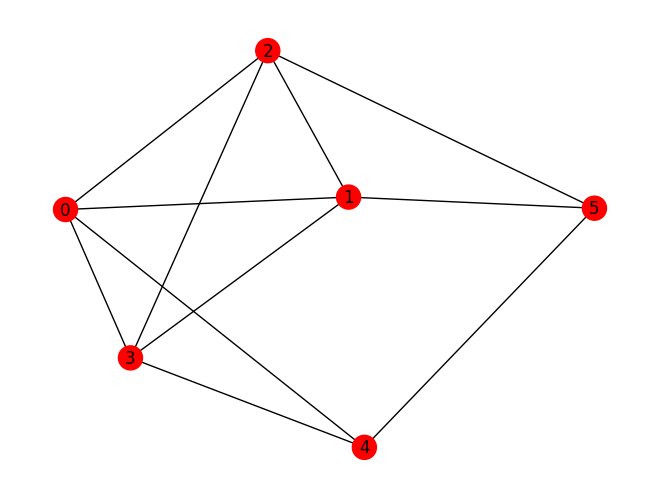

Episode 200, Reward: -76.50000000000058
Current MIS Set: {0, 1, 2, 3, 4, 5}


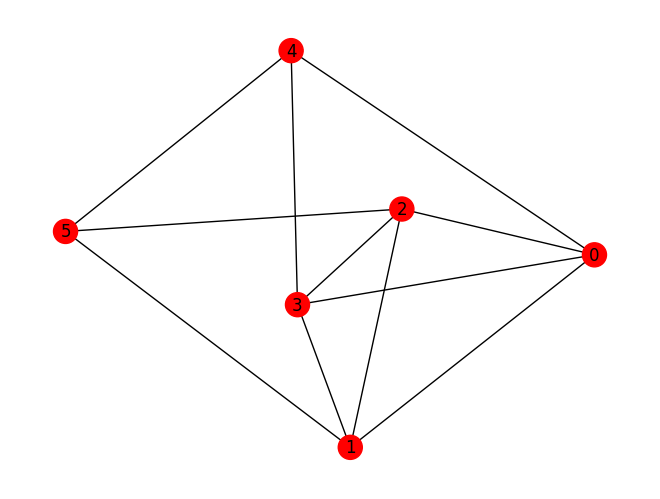

Episode 400, Reward: -60.10000000000032
Current MIS Set: {0, 1, 2, 3, 4, 5}


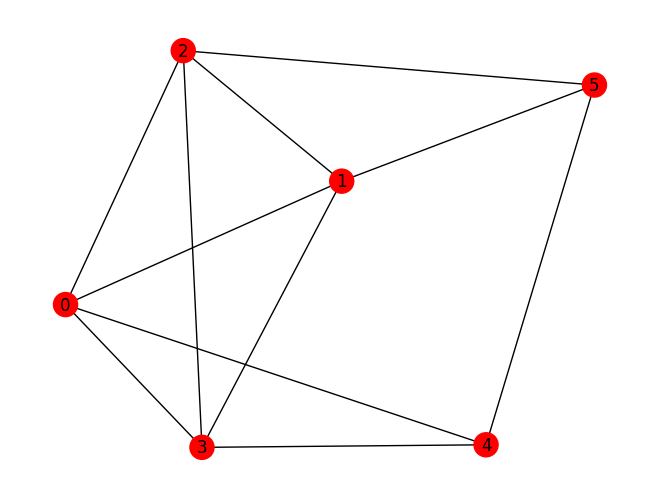

Episode 600, Reward: 58.699999999999335
Current MIS Set: {0, 1, 2, 3, 4, 5}


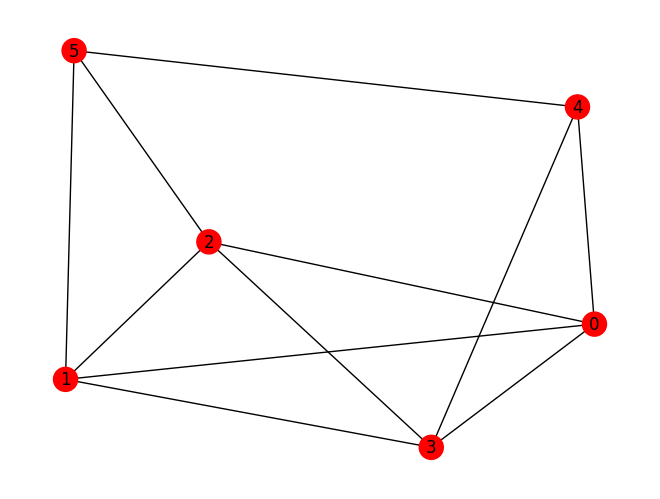

Episode 800, Reward: 78.49999999999936
Current MIS Set: {0, 1, 2, 3, 4, 5}


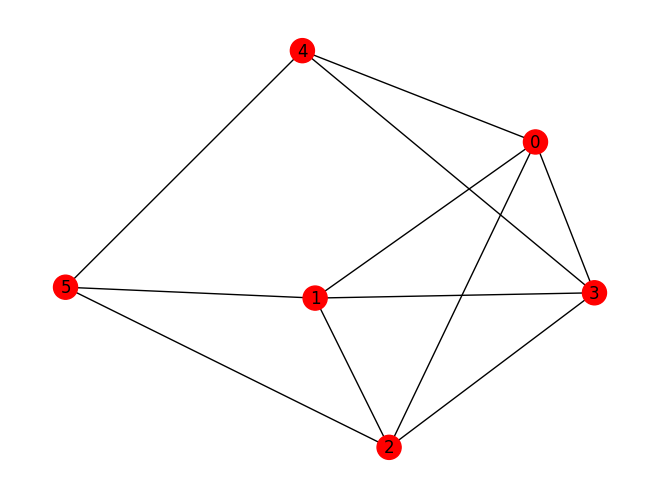

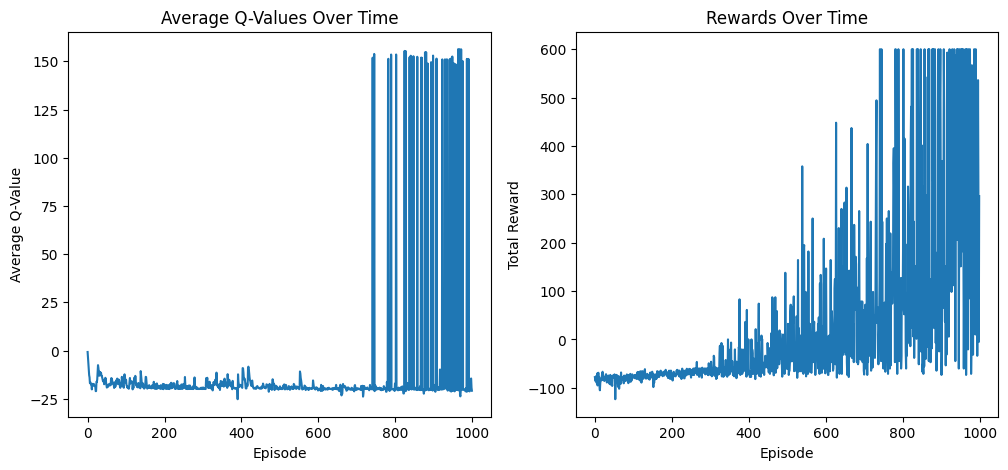

Maximum Independent Set: set()


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import networkx as nx

# Define the graph structure
adjacency_matrix = np.array([[0, 1, 1, 1, 1, 0],
                             [1, 0, 1, 1, 0, 1],
                             [1, 1, 0, 1, 0, 1],
                             [1, 1, 1, 0, 1, 0],
                             [1, 0, 0, 1, 0, 1],
                             [0, 1, 1, 0, 1, 0]])

# Create a NetworkX graph for visualization
G = nx.Graph(adjacency_matrix)  # Changed from DiGraph to Graph as adjacency is symmetric

# Define parameters
num_agents = len(adjacency_matrix)
num_episodes = 1000
max_steps_per_episode = 50
gamma = 0.99  # Discount factor
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
learning_rate = 0.001

# Define the Q-network architecture
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(num_agents, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 actions: include, exclude

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Q-networks for each agent
q_networks = [QNetwork() for _ in range(num_agents)]
optimizers = [optim.Adam(q.parameters(), lr=learning_rate) for q in q_networks]

def dynamic_local_reward(selected_nodes, agent, adjacency_matrix):
    if agent in selected_nodes:
        return -0.2
    else:
        neighbors = adjacency_matrix[agent]
        num_selected_neighbors = np.sum(neighbors[list(selected_nodes)])
        if num_selected_neighbors > 0:
            return -1.5 * num_selected_neighbors
        else:
            node_degree = np.sum(neighbors)
            reward = 1.5 + 0.2 * node_degree
            return np.clip(reward, -2, 2)  # Clipping reward to a maximum and minimum


# Max-Plus algorithm for Q-learning
def max_plus_update(q_values, next_q_values, reward):
    return reward + gamma * torch.max(next_q_values).item()

# Store episode rewards for monitoring and Q-value history
episode_rewards = []
q_value_history = []

epsilon = epsilon_start
for episode in range(num_episodes):
    state = np.zeros(num_agents)
    total_episode_reward = 0
    for step in range(max_steps_per_episode):
        for agent in range(num_agents):
            q_values = q_networks[agent](torch.tensor(state, dtype=torch.float32))
            if random.random() < epsilon:
                action = random.randint(0, 1)
            else:
                action = q_values.argmax().item()

            next_state = state.copy()
            if action == 0:
                next_state[agent] = 1
            reward = dynamic_local_reward(set(np.where(state == 1)[0]), agent, adjacency_matrix)

            total_episode_reward += reward
            next_q_values = q_networks[agent](torch.tensor(next_state, dtype=torch.float32))
            target = max_plus_update(q_values, next_q_values, reward)
            loss = nn.MSELoss()(q_values[action], torch.tensor(target, dtype=torch.float32))

            optimizers[agent].zero_grad()
            loss.backward()
            optimizers[agent].step()

            state = next_state

    episode_rewards.append(total_episode_reward)
    q_value_history.append(np.mean([q.max().item() for q in q_values]))
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    if episode % 200 == 0:
        print(f"Episode {episode}, Reward: {total_episode_reward}")
        current_mis_set = set(np.where(state == 1)[0])
        print("Current MIS Set:", current_mis_set)
        color_map = ['red' if node in current_mis_set else 'blue' for node in G.nodes()]
        nx.draw(G, node_color=color_map, with_labels=True)
        plt.show()

# Plotting average Q-values and rewards over time
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(q_value_history)
plt.title("Average Q-Values Over Time")
plt.xlabel("Episode")
plt.ylabel("Average Q-Value")

plt.subplot(1, 2, 2)
plt.plot(episode_rewards)
plt.title("Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

# Evaluation
def evaluate_policy(q_networks):
    selected_nodes = set()
    state = np.zeros(num_agents)
    for agent, q_network in enumerate(q_networks):
        q_values = q_network(torch.tensor(state, dtype=torch.float32))
        action = q_values.argmax().item()
        if action == 0:
            selected_nodes.add(agent)
            state[agent] = 1
    return selected_nodes

selected_nodes = evaluate_policy(q_networks)
print("Maximum Independent Set:", selected_nodes)


Episode 0, Reward: -86.20000000000232, Current MIS Set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} 
Episode 100, Reward: -2.200000000000034, Current MIS Set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} 
Episode 200, Reward: 39.100000000000755, Current MIS Set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} 
Episode 300, Reward: 77.59999999999965, Current MIS Set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} 
Episode 400, Reward: 80.99999999999943, Current MIS Set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} 
Episode 500, Reward: 112.6999999999968, Current MIS Set: {0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2

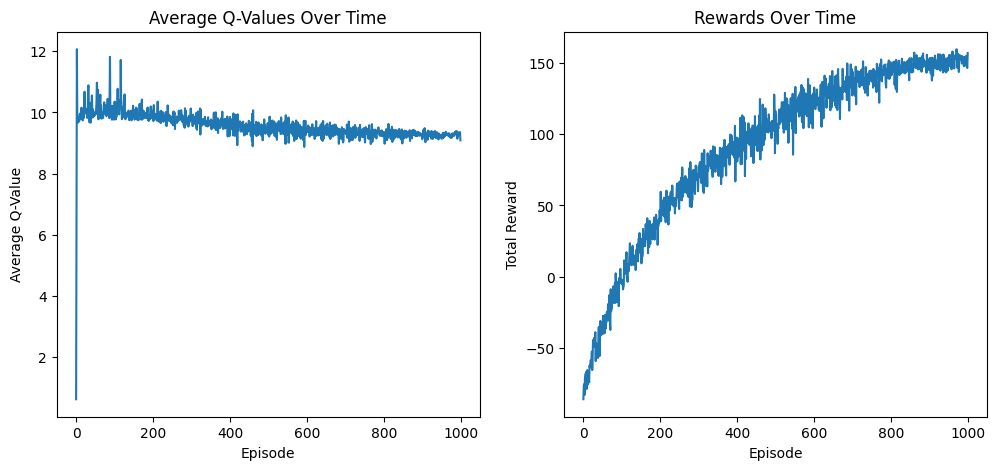

Maximum Independent Set: {27}


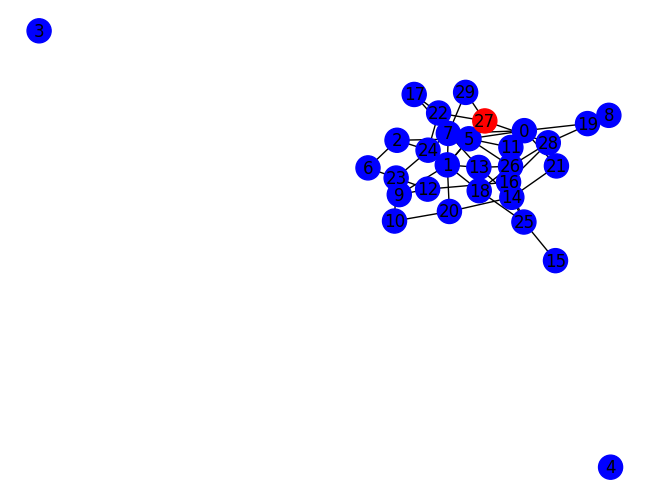

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import networkx as nx

# Define the graph structure
# Create an Erdős-Rényi graph
G = nx.erdos_renyi_graph(n=30, p=0.1)

# Convert the graph into an adjacency matrix (numpy array)
adjacency_matrix = nx.to_numpy_array(G)

# If you need the adjacency matrix as an integer matrix
adjacency_matrix = adjacency_matrix.astype(int)

# Define parameters
num_agents = len(adjacency_matrix)
num_episodes = 1000
max_steps_per_episode = 50
gamma = 0.99  # Discount factor
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
learning_rate = 0.001

# Define the Q-network architecture
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(num_agents, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)  # 2 actions: include, exclude

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize Q-networks for each agent
q_networks = [QNetwork() for _ in range(num_agents)]
optimizers = [optim.Adam(q.parameters(), lr=learning_rate) for q in q_networks]

# Define local reward function
def local_reward(selected_nodes, agent):
    if agent in selected_nodes:
        return -0.2  # Penalize selecting already selected node
    else:
        if not selected_nodes:
            return 0
        else:
            selected_nodes_list = list(selected_nodes)
            num_selected_neighbors = np.sum(adjacency_matrix[agent, selected_nodes_list])
            if num_selected_neighbors == 0:
                return 1
            else:
                return -1

# Max-Plus algorithm for Q-learning
def max_plus_update(q_values, next_q_values, reward):
    return reward + gamma * torch.max(next_q_values).item()

# Store episode rewards for monitoring and Q-value history
episode_rewards = []
q_value_history = []

epsilon = epsilon_start
for episode in range(num_episodes):
    state = np.zeros(num_agents)
    total_episode_reward = 0
    episode_q_values = []
    for step in range(max_steps_per_episode):
        for agent in range(num_agents):
            q_values = q_networks[agent](torch.tensor(state, dtype=torch.float32))
            episode_q_values.append(q_values.tolist())

            if random.random() < epsilon:
                action = random.randint(0, 1)
            else:
                action = q_values.argmax().item()

            if action == 0:  # Include node
                next_state = state.copy()
                next_state[agent] = 1
                reward = local_reward(set(np.where(state)[0]), agent)
            else:  # Exclude node
                next_state = state
                reward = 0.1  # Small positive reward for excluding

            total_episode_reward += reward

            next_q_values = q_networks[agent](torch.tensor(next_state, dtype=torch.float32))
            target = max_plus_update(q_values, next_q_values, reward)
            loss = nn.MSELoss()(q_values[action], torch.tensor(target, dtype=torch.float32))

            optimizers[agent].zero_grad()
            loss.backward()
            optimizers[agent].step()

            state = next_state

    episode_rewards.append(total_episode_reward)
    q_value_history.append(np.mean(episode_q_values))
    epsilon = max(epsilon_end, epsilon * epsilon_decay)  # Decaying epsilon

    if episode % 100 == 0 or episode==num_episodes:
        print(f"Episode {episode}, Reward: {total_episode_reward}, Current MIS Set: {set(np.where(state == 1)[0])} ")

# Plotting average Q-values and rewards over time
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(q_value_history)
plt.title("Average Q-Values Over Time")
plt.xlabel("Episode")
plt.ylabel("Average Q-Value")

plt.subplot(1, 2, 2)
plt.plot(episode_rewards)
plt.title("Rewards Over Time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

# Evaluation
def evaluate_policy(q_networks):
    selected_nodes = set()
    state = np.zeros(num_agents)
    for agent, q_network in enumerate(q_networks):
        q_values = q_network(torch.tensor(state, dtype=torch.float32))
        action = q_values.argmax().item()
        if action == 0:
            selected_nodes.add(agent)
            state[agent] = 1
    return selected_nodes

selected_nodes = evaluate_policy(q_networks)
print("Maximum Independent Set:", selected_nodes)

# Visualize the final MIS
color_map = ['red' if node in selected_nodes else 'blue' for node in G.nodes()]
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()
